###### Feature Information

PassengerID: Unique ID number

Survived: 0 = No, 1 = Yes

Pclass: Ticket class (1, 2, or 3)

Name: Passenger name

Sex: Male or Female

Age: Age in years

SibSp: # of siblings/spouses aboard the Titanic

Parch: # of parents/children aboard the Titanic

Ticket: Ticket #

Fare: Passenger fare

Cabin: Cabin number

Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

# Imports

In [66]:
import numpy as np
import pandas as pd
import pandas_profiling as pp

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Obtain

Load train & test data as dataframes from csv files

In [67]:
# Import training/testing data using pandas

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [68]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [69]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Scrub

Check training data features for any null values or non-numeric data

In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


###### There are several immediate issues with the data:

1) Missing (null) values in the 'Age', 'Cabin', and 'Embarked' features

2) Non-numeric data is present in the 'Name', 'Sex', 'Ticket', 'Cabin', and 'Embarked' features.

The points should be addressed before further meaningful data analysis is performed.

###### 1) Handing 'Age' missing values

In [71]:
# Check value counts of age

train.Age.value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002525D7D4C50>]],
      dtype=object)

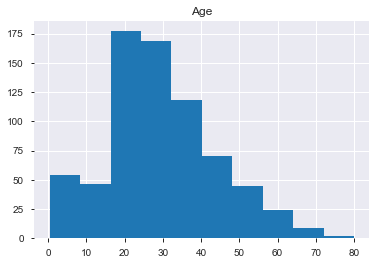

In [72]:
train.hist('Age')

In [73]:
# How many ages are missing?

train.Age.isna().sum()

177

In [74]:
# Replace nulls with median value for age

train.Age.fillna(train.Age.median(), inplace=True)

In [75]:
# Separate age data into bins for every 10 years, to smooth the effect of
# filling null ages with median age

train['age_bins'] = pd.cut(x=train['Age'], 
                           bins=[0, 10, 20, 30, 40, 50, 60, 70, 80],
                          labels=[5, 15, 25, 35, 45, 55, 65, 75])

In [76]:
# Convert data type to numeric

train['age_bins'] = train['age_bins'].astype('int64')

In [77]:
# Check updated value counts for age (25 = 20-30 yr bin)

train['age_bins'].value_counts()

25    407
35    155
15    115
45     86
5      64
55     42
65     17
75      5
Name: age_bins, dtype: int64

###### 2) Handle 'Cabin' missing values

Since most of the data is missing, it is best to drop this feature entirely

In [78]:
# Drop cabin feature

train.drop('Cabin', axis=1, inplace=True)

In [79]:
# Check to make sure 'Cabin' removed

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,age_bins
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,25
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,35
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,25
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,35
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,35


###### 3) Handle 'Embarked' missing values

In [80]:
# Let's see the distribution of values for 'Embarked'

train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [81]:
# Since most people embarked at 'S', we will fill the two null values with 'S'

train.Embarked.fillna('S', inplace=True)

train.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

Since 'Embarked' is stored categorically, want to convert this to dummy variables

In [82]:
dummies = pd.get_dummies(train.Embarked, prefix='Emb', drop_first=True)

In [83]:
train = pd.concat([train, dummies], axis=1)

In [84]:
train.drop('Embarked', axis=1, inplace=True)

In [85]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,age_bins,Emb_Q,Emb_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,25,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,35,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,25,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,35,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,35,0,1


###### 4) Handling 'Sex' dtype

Since 'Embarked' is stored categorically, want to convert this to dummy variables

In [86]:
s_dummies = pd.get_dummies(train.Sex, prefix='sex', drop_first=True)
train = pd.concat([train, s_dummies], axis=1)
train.drop('Sex', axis=1, inplace=True)

In [87]:
train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,age_bins,Emb_Q,Emb_S,sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,25,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,35,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,25,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,35,0,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,35,0,1,1


###### 5) Handling 'Name' and 'Ticket' features

Since I don't see any real way to extract meaningful information from these, I will drop these from my training data.

In [88]:
train.drop(['Name', 'Ticket'], axis=1, inplace=True)

In [89]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,age_bins,Emb_Q,Emb_S,sex_male
0,1,0,3,22.0,1,0,7.2500,25,0,1,1
1,2,1,1,38.0,1,0,71.2833,35,0,0,0
2,3,1,3,26.0,0,0,7.9250,25,0,1,0
3,4,1,1,35.0,1,0,53.1000,35,0,1,0
4,5,0,3,35.0,0,0,8.0500,35,0,1,1


###### Final check of first pass at scrubbing

In [90]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
age_bins       891 non-null int64
Emb_Q          891 non-null uint8
Emb_S          891 non-null uint8
sex_male       891 non-null uint8
dtypes: float64(2), int64(6), uint8(3)
memory usage: 58.4 KB


# Explore

Taking another look at each variable, so see if anything needs bo be adjusted before beginning modeling.

In [91]:
# Run pandas profiling report on our scrubbed training dataset

pp.ProfileReport(train)

I am now going to drop the 'Age' and 'PassengerId' features. 'Age' is highly correlated to 'age_bins' and will therefore be redundant, an 'PassengerId' isn't going to provide any useful information.

In [92]:
train.drop(['Age', 'PassengerId'], axis=1, inplace=True)

In [93]:
train.head()

,Survived,Pclass,SibSp,Parch,Fare,age_bins,Emb_Q,Emb_S,sex_male
0,0,3,1,0,7.2500,25,0,1,1
1,1,1,1,0,71.2833,35,0,0,0
2,1,3,0,0,7.9250,25,0,1,0
3,1,1,1,0,53.1000,35,0,1,0
4,0,3,0,0,8.0500,35,0,1,1


# Model

## Zero Rule (ZeroR) Classifier

This is a great baseline classifier for a binary classification problem like this. The ZeroR classifier simply predicts the majority class in your dataset (i.e., mode).

In [94]:
zero_r_clf = round(len(train.loc[train.Survived == 0]) / len(train), 2)

In [95]:
print(f"ZeroR (Baseline) Classifier Accuracy is: {zero_r_clf}")

ZeroR (Baseline) Classifier Accuracy is: 0.62


So, the baseline ZeroR classifier (which only predicts the majority class) will be right about 62% of the time. This is a good starting point for more sophisticated classifiers.

## Decision Tree Classifier

In [164]:
# First, need to define X and y in dataset

X = train.drop('Survived', axis=1)
y = train.Survived

In [174]:
# Instantiate a vanilla decision tree clf

dt_clf = DecisionTreeClassifier()

In [175]:
# Instantiate the KFold object with 10 folds

cv = KFold(n_splits=5, random_state=2, shuffle=True)

In [178]:
scores = []
for train_index, test_index in cv.split(X):
    dt_clf.fit(X.iloc[train_index], y.iloc[train_index])
    y_pred = dt_clf.predict(X.iloc[test_index])
    y_true = y.iloc[test_index]
    scores.append(accuracy_score(y_true, y_pred))

print(f"Accuracy Scores: {scores}")
print(f"Mean Cross Val. Acc.: {np.mean(scores)}")
    

Accuracy Scores: [0.7653631284916201, 0.8426966292134831, 0.8426966292134831, 0.7808988764044944, 0.7921348314606742]
Mean Cross Val. Acc.: 0.804758018956751


A vanilla Decision Tree classifier can achieve an accuracy of ~ 80% using 5-Fold cross validation on the training dataset.